In [1]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy


from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from Efficiencies import finding_file, get_channels_eff, set_raw_counts
from Optimization import Optimizer, function_fidelity, FidelityResults

from DensityMatrix import DensityMatrix

In [2]:
Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

In [3]:
### Counting files and printing them to make sure we are analysing the correct data ###
n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
#working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringMaliciousBPF\BPF202205262200"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
#filenames = [i for i in glob.glob("StateTomography*")]
filenames.sort(key=os.path.getmtime)

index_to_file = {}

for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        index_to_file[index] = f"{filename}\\{filenames_aux_second}"
        n_files+=1
os.chdir(working_dir)

In [10]:
index_to_file[0]

'ChannelSTSteeringHonest202205241455\\StateTomography202205241431'

In [5]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
#working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringMaliciousBPF\BPF202205262200"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
#filenames = [i for i in glob.glob("StateTomography*")]
filenames.sort(key=os.path.getmtime)

qubit_number=2

state_after=[]#np.zeros((int(n_files/2),2**qubit_number,2**qubit_number), dtype=complex)
state_before=[]#np.zeros((int(n_files/2),2**qubit_number,2**qubit_number), dtype=complex)

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################

#for index in range(n_files):
    
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        #print(index, filenames_aux_second)
        os.chdir(working_dir+'\\'+filename+'\\'+filenames_aux_second+'\\'+'StateTomo')
        datafiles=[i for i in glob.glob("*")]
                
        ##Calculating the efficiencies of each detector
        efficiencies=get_channels_eff(datafiles, os.getcwd())
    
        ### Opening the data files and writing the data in counts_aux array
        counts_aux=set_raw_counts(datafiles, qubit_number, os.getcwd())
        xp_counts=np.array(np.transpose(counts_aux))

        statetomo=LRETomography(int(qubit_number), xp_counts, 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
        statetomo.run(correct_eff=efficiencies, print_nc=False)
        statetomo.quantum_state.get_density_matrix()
        
        ### The 'e' and 'r' serve to distinguish between tomography before and after, respectively
        ### We want to save them in different arrays because we need them for different things
        if filenames_aux_second[-8]=='e':
            state_before.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
            #print('\n Fast maximum likelihood estimation: \n', state_before[-1], '\n')
            
        elif filenames_aux_second[-8]=='r':
            state_after.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
            #print('\n Fast maximum likelihood estimation: \n', state_after[-1], '\n')
            

In [6]:
#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

In [14]:
### Optimization of the fidelities with the unitaries ###
fid=np.zeros((n_files))
optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')

guess=np.array([0, 0, 0, 0, 0, 0])
bounds=[(-np.pi,np.pi)]*6
results = []

opt=Optimizer(guess, function_fidelity, results=FidelityResults)

for index in range(1):#int(n_files/2-1)):
    result=opt.optimize(dirinv_after[index], bell, bounds=bounds)
    results.append(result)

Generation 0 has ChiSquare: -0.999815
Generation 50 has ChiSquare: -0.999944
Generation 100 has ChiSquare: -0.999944
Generation 150 has ChiSquare: -0.999944
Generation 200 has ChiSquare: -0.999944
Generation 250 has ChiSquare: -0.999944
Generation 300 has ChiSquare: -0.999944
Generation 350 has ChiSquare: -0.999944
Generation 400 has ChiSquare: -0.999944
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.999944
         Iterations: 446
         Function evaluations: 44700


In [8]:
error_runs=5

mu=np.zeros((n_files))
std=np.zeros((n_files))


dm = state_before[-1]
dm.calculate_errors(xp_counts, error_runs, bell)
dm.std

0.0037138439589008087 9.803876316165033e-05


9.803876316165033e-05

In [51]:
import xlsxwriter
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'File')
worksheet.write('D1', 'Fidelity')
worksheet.write('E1', 'Uncertainty')
 
# Finally, close the Excel file
# via the close() method.

counter=0
filenames = [i for i in glob.glob("Channel*")]
#filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        worksheet.write('A'+str(counter+2), counter)
        worksheet.write('B'+str(counter+2),filename)
        worksheet.write('C'+str(counter+2),filenames_aux_second)
        worksheet.write('D'+str(counter+2),np.round(mu[counter],5))
        worksheet.write('E'+str(counter+2),np.round(std[counter],5))
        counter+=1
        
workbook.close()

0.9902684777264444 0.00020653115021695384
52.89906916890987 0.9901366785908849 0.00012899069168909808


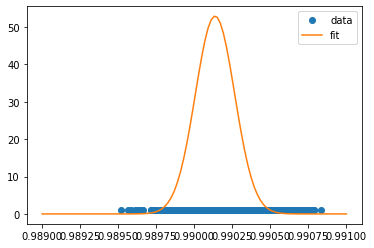

In [52]:
### IF WE WANT TO CHECK THE FIT TO THE UNCERTARTAINTY
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(50,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()